<a href="https://colab.research.google.com/github/audreyemmely/pln/blob/main/pln_lista3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resolução Lista 3**

---

Audrey Emmely Rodrigues Vasconcelos

Karen Nayara Gomes da Silva

In [ ]:
#from google.colab import files
#uploaded = files.upload()
# upando train_data e test_data_solution

## Questão 1
Escolha 10 documentos da base, e determine seu documento mais parecido
(que não pode ser ele mesmo), usando:

a) Representação vetorial CountVectorizer com similaridade do cosseno;

b) Representação vetorial TF-IDF com similaridade do cosseno.

Mostre pelo menos um trecho de cada par de documentos parecidos que justifique
essa semelhança.

In [ ]:
import pandas as pd
import numpy as np
import random
import re
import nltk
from IPython.core.display import display, HTML
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('train_data.txt', sep =':::', header = None, engine = 'python', nrows = 6000)
df.columns = ['id', 'title', 'genre', 'description']
df2 = pd.read_csv('test_data_solution.txt', sep =':::', header = None, engine = 'python', nrows = 6000)
df2.columns = ['id', 'title', 'genre', 'description']

In [ ]:
df3 = pd.concat([df, df2], ignore_index=True)
df3.drop('id', axis=1, inplace=True)
comedy = df3.loc[df3['genre'].str.contains('comedy')]
drama = df3.loc[df3['genre'].str.contains('drama')]
dataset = pd.concat([comedy, drama], ignore_index=True)

In [ ]:
def preprocess(description):
  description = re.sub(r'\w*\d\w*', '', description) #remove todas as palavras que contêm números
  description = re.sub(r'[^a-zA-Z ]', '', description.lower())
  return re.sub(r'\s+', ' ', description) #retira espaços repetidos

In [ ]:
dataset['description'] = dataset.description.apply(preprocess)

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(description):
    tokenized_text = nltk.word_tokenize(description, language='english')
    return " ".join([token for token in tokenized_text if token not in stop_words])

In [ ]:
dataset['description'] = dataset.description.apply(remove_stopwords)

In [ ]:
dataset

,title,genre,description
0,"""Pink Slip"" (2009)",comedy,tough economic times max joey run ideas discov...
1,Babylon Vista (2001),comedy,frankie reno child star tv show thirty years a...
2,Söderpojkar (1941),comedy,gang unemployed itinerant musicians play south...
3,Tunnel Vision (1976),comedy,committee investigating tvs first uncensored n...
4,"""The Young Professionals"" (2015)",comedy,whether blocking mouse holes running landlords...
...,...,...,...
4664,Hello & Goodbye (????),drama,wounds still open recent end year relationship...
4665,Nyab Siab Zoo (2009),drama,death lady va chas husband two sons returns no...
4666,Saving the Lives of Children (2008),drama,series monologues tell tales underground schoo...
4667,Charachar (1994),drama,lakha comes family bird catchers questions val...


In [ ]:
tfidf_X = TfidfVectorizer().fit_transform(dataset.description)
count_X = CountVectorizer().fit_transform(dataset.description)

tfidf_similarity_matrix = cosine_similarity(tfidf_X)
count_similarity_matrix = cosine_similarity(count_X)

In [ ]:
np.fill_diagonal(tfidf_similarity_matrix, 0.0)
np.fill_diagonal(count_similarity_matrix, 0.0)

result = [
    {
        'doc': dataset.iloc[i],
        'tfidf_similar_doc': dataset.iloc[tfidf_similarity_matrix[i, :].argmax()],
        'tfidf_similarity': tfidf_similarity_matrix[i, :].max(),
        'count_similar_doc': dataset.iloc[count_similarity_matrix[i, :].argmax()],
        'count_similarity': count_similarity_matrix[i, :].max(),
    }
    for i in [random.randint(0, len(dataset)) for _ in range(10)]
]    

In [ ]:
%%html
<style>
    .col {
        height: 100%;
        padding-left: 16px;
        padding-right: 16px;
        padding-top: 8px;
        padding-bottom: 8px;
    }
</style>

### 1.a) Representação vetorial CountVectorizer com similaridade do cosseno;

### 1.b) Representação vetorial TF-IDF com similaridade do cosseno.

In [ ]:
for r in result:
    title = r['doc'].title if r['doc'].title != '' else r['doc'].description[:150] + '...'
    movie = '<span>%(title)s</span> <span>%(description)s</span>' 
    desc_length = 300
    
    tfidf_content = movie % ({
        'title': r['tfidf_similar_doc'].title,
        'description': r['tfidf_similar_doc'].description[:desc_length] + '...',
    })
    count_content = movie % ({ 
        'title': r['count_similar_doc'].title,
        'description': r['count_similar_doc'].description[:desc_length] + '...',
    })
    
    display(HTML('''
    <div style="margin: 8px; border: 1px solid lightgray">
        <div style="text-align: center;background-color: whitesmoke;padding: 8px"><u r['doc'].title >''' + title + '''</u></div>
        <div>
            <div>
                <div class="col">
                <div><strong>TfidfVectorizer: </strong>''' + str(r['tfidf_similarity'])[:6] + '''</div>
                <div>''' + tfidf_content + '''</div>
                </div>
            </div>
            <div>
                <div class="col">
                <div><strong>CountVectorizer: </strong>''' + str(r['count_similarity'])[:6] + '''</div>
                <div>''' + count_content + '''</div>
                </div>
            </div>
        </div>
    </div>
    '''))

## Questão 2
Elabore um problema de classificação binária de textos coerente com sua
base.

a) Determine o rótulo dos documentos (separando os documentos em classes
bem definidas).

b) Extraia as representações vetoriais com CountVectorizer e TF-IDF.

c) Treine um classificador baseado em cada uma das duas representações vetoriais e Regressão Logística usando validação cruzada com 70% das amostras selecionadas para treino e 30% para teste. Exiba as matrizes de confusão,
métricas de acurácia, precisão, recall e F1 score.

d) Faça o mesmo para o classificador Naive-Bayes.

e) Faça o mesmo para um outro classificador de sua preferência (pesquise na
biblioteca Scikit-learn).

f) Compare os 6 resultados.


### 2.a) Determine o rótulo dos documentos (separando os documentos em classes bem definidas).

In [ ]:
lbl_to_ind = {
    ' comedy ': 0, ' drama ': 1, 
}
y = [lbl_to_ind[l] for l in dataset.genre.values[:4669]]

### 2.b) Extraia as representações vetoriais com CountVectorizer e TF-IDF.

In [ ]:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X, y, test_size=0.3)
count_X_train, count_X_test, count_y_train, count_y_test = train_test_split(count_X, y, test_size=0.3)

### 2.c) Treine um classificador baseado em cada uma das duas representações vetoriais e Regressão Logística usando validação cruzada com 70% das amostras selecionadas para treino e 30% para teste. Exiba as matrizes de confusão, métricas de acurácia, precisão, recall e F1 score.

In [ ]:
# Regressão Logística com tfidf
cl = LogisticRegression().fit(tfidf_X_train.toarray(), tfidf_y_train)
tfidf_y_pred = cl.predict(tfidf_X_test.toarray())

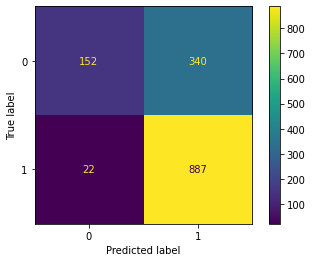

In [ ]:
plot_confusion_matrix(cl, tfidf_X_test.toarray(), tfidf_y_test)
plt.show()

In [ ]:
accuracy_lr_tfidf = accuracy_score(tfidf_y_test, tfidf_y_pred)
precision_lr_tfidf = precision_score(tfidf_y_test, tfidf_y_pred)
recall_lr_tfidf = recall_score(tfidf_y_test, tfidf_y_pred)
f1_lr_tfidf = f1_score(tfidf_y_test, tfidf_y_pred)

print("Regressão Logísitca e TF-IDF\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_lr_tfidf, precision_lr_tfidf, recall_lr_tfidf, f1_lr_tfidf))

Regressão Logísitca e TF-IDF
Acurácia: 0.7416131334760885
Precisão: 0.7229013854930725
Recall: 0.9757975797579758
F1 Score: 0.8305243445692884



In [ ]:
# Regressão Logística com countvectorizer
cl = LogisticRegression().fit(count_X_train.toarray(), count_y_train)
count_y_pred = cl.predict(count_X_test.toarray())

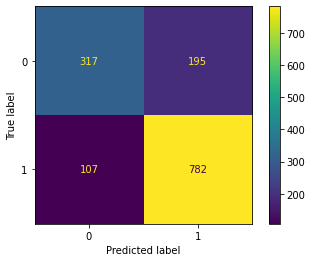

In [ ]:
plot_confusion_matrix(cl, count_X_test.toarray(), count_y_test)
plt.show()

In [ ]:
accuracy_lr_count = accuracy_score(count_y_test, count_y_pred)
precision_lr_count = precision_score(count_y_test, count_y_pred)
recall_lr_count = recall_score(count_y_test, count_y_pred)
f1_lr_count = f1_score(count_y_test, count_y_pred)

print("Regressão Logísitca e CountVectorizer\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_lr_count, precision_lr_count, recall_lr_count, f1_lr_count))

Regressão Logísitca e CountVectorizer
Acurácia: 0.7844396859386152
Precisão: 0.8004094165813715
Recall: 0.8796400449943758
F1 Score: 0.8381564844587354



### 2.d) Faça o mesmo para o classificador Naive-Bayes.

In [ ]:
# Naive Bayes com tfidf

cl_nb = MultinomialNB().fit(tfidf_X_train.toarray(), tfidf_y_train)
tfidf_y_pred_nb = cl_nb.predict(tfidf_X_test.toarray())

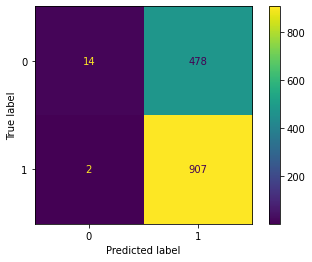

In [ ]:
plot_confusion_matrix(cl_nb, tfidf_X_test.toarray(), tfidf_y_test)
plt.show()

In [ ]:
accuracy_nb_tfidf = accuracy_score(tfidf_y_test, tfidf_y_pred_nb)
precision_nb_tfidf = precision_score(tfidf_y_test, tfidf_y_pred_nb)
recall_nb_tfidf = recall_score(tfidf_y_test, tfidf_y_pred_nb)
f1_nb_tfidf = f1_score(tfidf_y_test, tfidf_y_pred_nb)

print("Naive Bayes e TF-IDF\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_nb_tfidf, precision_nb_tfidf, recall_nb_tfidf, f1_nb_tfidf))

Naive Bayes e TF-IDF
Acurácia: 0.6573875802997858
Precisão: 0.6548736462093863
Recall: 0.9977997799779978
F1 Score: 0.7907585004359198



In [ ]:
# Naive Bayes com countvectorizer

cl_nb = MultinomialNB().fit(count_X_train.toarray(), count_y_train)
count_y_pred_nb = cl_nb.predict(count_X_test.toarray())

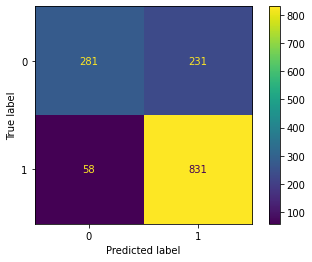

In [ ]:
plot_confusion_matrix(cl_nb, count_X_test.toarray(), count_y_test)
plt.show()

In [ ]:
accuracy_nb_count = accuracy_score(count_y_test, count_y_pred_nb)
precision_nb_count = precision_score(count_y_test, count_y_pred_nb)
recall_nb_count = recall_score(count_y_test, count_y_pred_nb)
f1_nb_count = f1_score(count_y_test, count_y_pred_nb)

print("Naive Bayes e CountVectorizer\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_nb_count, precision_nb_count, recall_nb_count, f1_nb_count))

Naive Bayes e CountVectorizer
Acurácia: 0.793718772305496
Precisão: 0.7824858757062146
Recall: 0.9347581552305961
F1 Score: 0.8518708354689901



### 2.e) Faça o mesmo para um outro classificador de sua preferência (pesquise na biblioteca Scikit-learn).

In [ ]:
# SVM com tfidf

cl_svm = LinearSVC().fit(tfidf_X_train.toarray(), tfidf_y_train)
tfidf_y_pred_svm = cl_svm.predict(tfidf_X_test.toarray())

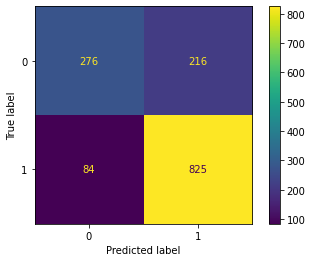

In [ ]:
plot_confusion_matrix(cl_svm, tfidf_X_test.toarray(), tfidf_y_test)
plt.show()

In [ ]:
accuracy_svm_tfidf = accuracy_score(tfidf_y_test, tfidf_y_pred_svm)
precision_svm_tfidf = precision_score(tfidf_y_test, tfidf_y_pred_svm)
recall_svm_tfidf = recall_score(tfidf_y_test, tfidf_y_pred_svm)
f1_svm_tfidf = f1_score(tfidf_y_test, tfidf_y_pred_svm)

print("SVM e TF-IDF\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_svm_tfidf, precision_svm_tfidf, recall_svm_tfidf, f1_svm_tfidf))

SVM e TF-IDF
Acurácia: 0.7858672376873662
Precisão: 0.792507204610951
Recall: 0.9075907590759076
F1 Score: 0.846153846153846



In [ ]:
# SVM com countvectorizer

cl_svm = LinearSVC().fit(count_X_train.toarray(), count_y_train)
count_y_pred_svm = cl_svm.predict(count_X_test.toarray())

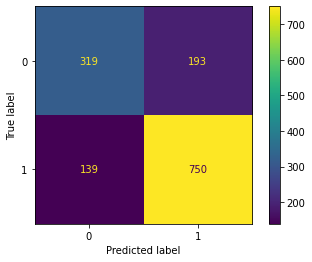

In [ ]:
plot_confusion_matrix(cl_svm, count_X_test.toarray(), count_y_test)
plt.show()

In [ ]:
accuracy_svm_count = accuracy_score(count_y_test, count_y_pred_svm)
precision_svm_count = precision_score(count_y_test, count_y_pred_svm)
recall_svm_count = recall_score(count_y_test, count_y_pred_svm)
f1_svm_count = f1_score(count_y_test, count_y_pred_svm)

print("SVM e CountVectorizer\nAcurácia: {}\nPrecisão: {}\nRecall: {}\nF1 Score: {}\n".format(accuracy_svm_count, precision_svm_count, recall_svm_count, f1_svm_count))

SVM e CountVectorizer
Acurácia: 0.7630264097073519
Precisão: 0.7953340402969247
Recall: 0.843644544431946
F1 Score: 0.8187772925764192



### 2.f) Compare os 6 resultados

In [ ]:
lr_count_results = [accuracy_lr_count, precision_lr_count, recall_lr_count, f1_lr_count]
lr_tfidf_results = [accuracy_lr_tfidf, precision_lr_tfidf, recall_lr_tfidf, f1_lr_tfidf]
nb_count_results = [accuracy_nb_count,precision_nb_count, recall_nb_count,f1_nb_count]
nb_tfidf_results = [accuracy_nb_tfidf, precision_nb_tfidf,recall_nb_tfidf, f1_nb_tfidf]
svm_count_results = [accuracy_svm_count,precision_svm_count, recall_svm_count,f1_svm_count]
svm_tfidf_results = [accuracy_svm_tfidf,precision_svm_tfidf, recall_svm_tfidf,f1_svm_tfidf]

data_results2 = {
    'Regression with Count': lr_count_results,
    'Regression with TF-IDF': lr_tfidf_results,
    'Naive Bayes with Count': nb_count_results,
    'Naive Bayes with TF-IDF': nb_tfidf_results,
    'SVM with Count': svm_count_results,
    'SVM with TF-IDF': svm_tfidf_results,
}

index_values2 = ['accuracy', 'precision', 'recall', 'f1']
pd.set_option('display.max_columns', None)

df_results2 = pd.DataFrame(data_results2, index=index_values2)

df_results2

           Regression with Count  Regression with TF-IDF  \
accuracy                0.784440                0.741613   
precision               0.800409                0.722901   
recall                  0.879640                0.975798   
f1                      0.838156                0.830524   

           Naive Bayes with Count  Naive Bayes with TF-IDF  SVM with Count  \
accuracy                 0.793719                 0.657388        0.763026   
precision                0.782486                 0.654874        0.795334   
recall                   0.934758                 0.997800        0.843645   
f1                       0.851871                 0.790759        0.818777   

           SVM with TF-IDF  
accuracy          0.785867  
precision         0.792507  
recall            0.907591  
f1                0.846154  


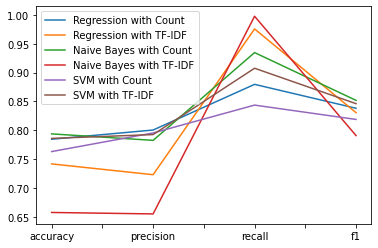

In [ ]:
df_results2.plot()
plt.show()

Podemos analisar que obtivemos a **maior acurácia** quando utilizamos o **Naive Bayes com CountVectorizer**, **precisão mais alta** utilizando **Regressão Logística com CountVectorizer**, **maior recall** utilizando **Naive Bayes com TF-IDF** e **maior F1** utilizando **Naive Bayes com CountVectorizer**.

**Referências**

[Basics of CountVectorizer](https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c)

[TF-IDF Vectorizer scikit-learn](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a)

[Cosine Similarity – Understanding the math and how it works (with python codes)](https://www.machinelearningplus.com/nlp/cosine-similarity/)

[Split Your Dataset With scikit-learn's train_test_split()](https://realpython.com/train-test-split-python-data/)